In [136]:
# Категориальный бустинг по файлу с исключенными аномальными значениями цен квартир
# Ячейки создания и фильтрации итогового дата-сета приведены ниже
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

df = pd.read_csv('RussianRealEstateNew.csv')

columns_to_check = ['geo_lat', 'geo_lon', 'level', 'levels', 'rooms', 'area', 
                    'kitchen_area', 'object_type', 'building_type', 'region', 'date', 'price']
df = df.sample(n=3500000, random_state=18)
df = df.dropna(subset=columns_to_check)
print(df.shape[0])
X = df[['geo_lat', 'geo_lon', 'level', 'levels', 'rooms', 'area', 
                    'kitchen_area', 'object_type', 'building_type', 'region', 'date']]
y = df['price']

categorical_columns = ['object_type', 'building_type', 'region', 'date', 'level', 'levels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)

model = CatBoostRegressor(iterations=1200, learning_rate=0.04, depth=16, cat_features=categorical_columns)

model.fit(X_train, y_train)

print(f'R² на тестовой выборке: {model.score(X_test, y_test)}')

feature_importances = model.get_feature_importance()
print('Важность признаков:')
for feature, importance in zip(X.columns, feature_importances):
    print(f"{feature}: {importance}")

model.save_model('russian_realtor_model_advanced.cbm')

3500000
0:	learn: 3919165.5191045	total: 6.4s	remaining: 2h 7m 54s
1:	learn: 3803440.6764307	total: 13s	remaining: 2h 9m 24s
2:	learn: 3692164.5245603	total: 19.7s	remaining: 2h 11m 1s
3:	learn: 3586786.5147278	total: 25.9s	remaining: 2h 8m 50s
4:	learn: 3485870.3256457	total: 32.5s	remaining: 2h 9m 37s
5:	learn: 3389702.7694717	total: 38.8s	remaining: 2h 8m 38s
6:	learn: 3298582.5481328	total: 45s	remaining: 2h 7m 56s
7:	learn: 3211506.8702330	total: 51.6s	remaining: 2h 8m 3s
8:	learn: 3126807.7598850	total: 57.5s	remaining: 2h 6m 48s
9:	learn: 3047013.3682847	total: 1m 2s	remaining: 2h 4m 52s
10:	learn: 2971230.7107191	total: 1m 9s	remaining: 2h 4m 20s
11:	learn: 2898816.7005764	total: 1m 14s	remaining: 2h 3m 40s
12:	learn: 2829715.8621633	total: 1m 20s	remaining: 2h 3m 1s
13:	learn: 2764279.4524064	total: 1m 26s	remaining: 2h 2m 21s
14:	learn: 2702067.5969939	total: 1m 32s	remaining: 2h 2m 6s
15:	learn: 2643302.5428808	total: 1m 38s	remaining: 2h 1m 39s
16:	learn: 2587994.6099164	to

In [5]:
# Ячейка в которой можно подставить в модель интересующие данные 
from catboost import CatBoostRegressor
import pandas as pd

model = CatBoostRegressor()
model.load_model('russian_realtor_model_advanced.cbm')

newdata = {
    'geo_lat': [55.949990], 
    'geo_lon': [37.490982],
    'level': [6], 
    'levels': [9], 
    'rooms': [3], 
    'area': [55], 
    'kitchen_area': [6], 
    'object_type': [0], 
    'building_type': [2], 
    'region': [81],
    'date': ['2021-05-01']
}

features = pd.DataFrame(newdata)

predicted_price = model.predict(features)

print(f'Предсказанная цена: {predicted_price}')

Предсказанная цена: [8215818.40556484]


Средняя ошибка модели: 11.48%


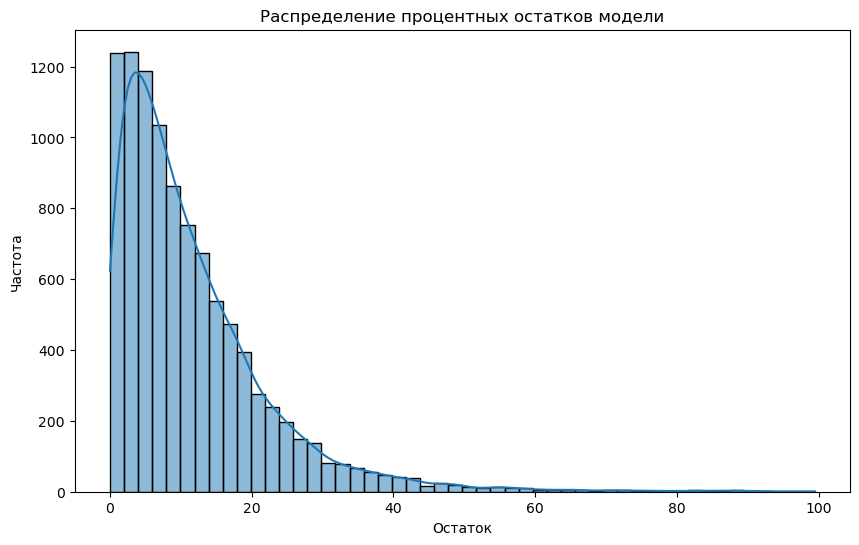

In [15]:
# Проверка ошибок по строкам из файла
# Следующие ячейки - предобработка данных перед обучением этой модели
from catboost import CatBoostRegressor
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
t = 0
s = []

model = CatBoostRegressor()
model.load_model('russian_realtor_model_advanced.cbm')

df = pd.read_csv('RussianRealEstateNew.csv')

for i in range(10000):
    r = random.randint(1, 3500000)
    row_index = r
    single_row = df.iloc[row_index][['geo_lat', 'geo_lon', 'level', 'levels', 'rooms', 'area', 
                                 'kitchen_area', 'object_type', 'building_type', 'region', 'date']].values.reshape(1, -1)

    predicted_price = model.predict(single_row)
    real_price = df.iloc[row_index]['price']
    w = abs(round((predicted_price[0] - real_price) * 100/real_price, 2))
    if w < 100:
        t += w
        s.append(w)

print(f'Средняя ошибка модели: {round(t/10000, 2)}%')

plt.figure(figsize=(10, 6))
sns.histplot(s, bins=50, kde=True)
plt.title('Распределение процентных остатков модели')
plt.xlabel('Остаток')
plt.ylabel('Частота')
plt.show()

In [ ]:
# Преобразование parquet-файла в csv с целью более удобного редактирования дата-сета
import pandas as pd
import pyarrow.parquet as pq

table = pq.read_table('RussianRealEstate.parquet')
df = table.to_pandas()
df.to_csv('RussianRealEstate.csv', index=False)

In [ ]:
# Ячейка для выведения топа по какому-то показателю с целью оценки того, насколько в целом крайние значения показателей разумно использовать в модели
# Меняя показатели по которым идет вывод и количество наблюдений в топе можно определить границы "нормальности"
# В следующей ячейке они используются для фильтрации дата-сета перед обучением
import duckdb

query = """
SELECT 
    area,
    region,
    date,
    price,
    geo_lat,
    geo_lon,
    price/area AS priceM
FROM read_parquet('RussianRealEstate.parquet')
ORDER BY geo_lat ASC
LIMIT 30
"""

result = duckdb.query(query).df()
print(result)

In [134]:
# Фильтрация дата-сета перед обучением
import pandas as pd

df = pd.read_csv('RussianRealEstate.csv')
df_filtered = df[(df['price'] >= 1000000) & (df['price'] <= 100000000)
    & (df['area'] >= 16) & (df['area'] <= 125) & (df['price']/df['area'] >= 35000)]
df_filtered.to_csv('RussianRealEstateNew.csv', index=False)

In [ ]:
# Создание объединенного parquet-файла вместе с предсказаниями модели
import pandas as pd
from catboost import CatBoostRegressor
import pyarrow.parquet as pq
import pyarrow as pa

df1 = pd.read_parquet('file1.parquet')
df2 = pd.read_parquet('file2.parquet')

df_combined = pd.concat([df1, df2], ignore_index=True)

print(f"Размер объединённого DataFrame: {df_combined.shape}")

model = CatBoostRegressor()
model.load_model('russian_realtor_model_advanced.cbm')

X = df_combined[['geo_lat', 'geo_lon', 'level', 'levels', 'rooms', 'area', 
                 'kitchen_area', 'object_type', 'building_type', 'region', 'date']]

y_pred = model.predict(X)

df_combined['predicted_price'] = y_pred

table = pa.Table.from_pandas(df_combined)

pq.write_table(table, 'combined_with_predictions.parquet')

In [132]:
# Объединение двух parquet-файлов
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa

df1 = pd.read_parquet('Российская недвижимость.parquet')
df2 = pd.read_parquet('Российская недвижимость2.parquet')

df_combined = pd.concat([df1, df2], ignore_index=True)
table = pa.Table.from_pandas(df_combined)
pq.write_table(table, 'RussianRealEstate.parquet')

In [172]:
import pandas as pd

df = pd.read_csv('RussianRealEstateNew.csv', low_memory=False)
df.describe()

,price,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
count,4.558325e+06,4.558325e+06,4.558325e+06,4.558325e+06,4.558325e+06,4.558325e+06,4.558325e+06,4.558325e+06,4.558325e+06,4.558325e+06,4.558325e+06
mean,4.504413e+06,5.404147e+01,5.078348e+01,3.871658e+03,1.976283e+00,6.533417e+00,1.204061e+01,1.709234e+00,5.205681e+01,1.064915e+01,3.718227e+00
std,4.033698e+06,4.724679e+00,1.991723e+01,3.133860e+03,1.029692e+00,5.121609e+00,6.714191e+00,1.019232e+00,1.916621e+01,8.993500e+00,4.448990e+00
min,1.000000e+06,4.145906e+01,1.989020e+01,3.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,-2.000000e+00,1.600000e+01,1.000000e-02,1.000000e+00
25%,2.325740e+06,5.333397e+01,3.765221e+01,2.661000e+03,1.000000e+00,3.000000e+00,6.000000e+00,1.000000e+00,3.800000e+01,7.000000e+00,1.000000e+00
50%,3.350000e+06,5.556232e+01,3.973586e+01,2.871000e+03,2.000000e+00,5.000000e+00,1.000000e+01,2.000000e+00,4.760000e+01,1.000000e+01,1.000000e+00
75%,5.200000e+06,5.632819e+01,6.075020e+01,5.520000e+03,3.000000e+00,9.000000e+00,1.700000e+01,2.000000e+00,6.300000e+01,1.250000e+01,1.100000e+01
max,1.000000e+08,7.198040e+01,1.587133e+02,6.188800e+04,5.000000e+00,3.900000e+01,3.900000e+01,9.000000e+00,1.250000e+02,9.999000e+03,1.100000e+01


In [2]:
# Создание интерактивной html-карты с номером региона, датой объявления, площадью и стоимостью квартиры
import folium
import pandas as pd

df = pd.read_csv('RussianRealEstate.csv').sample(n=15000, random_state=42)

m = folium.Map(location=[df['geo_lat'].mean(), df['geo_lon'].mean()], zoom_start=10)

for i in range(len(df)):
    popup_info = f"""
    <strong>Регион:</strong> {df.iloc[i]['region']}<br>
    <strong>Дата:</strong> {df.iloc[i]['date']}<br>
    <strong>Площадь:</strong> {df.iloc[i]['area']} м²<br>
    <strong>Цена:</strong> {df.iloc[i]['price']} руб.
    """
    
    folium.CircleMarker(
        location=[df.iloc[i]['geo_lat'], df.iloc[i]['geo_lon']],
        radius=5, 
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.6,
        popup=folium.Popup(popup_info, max_width=300) 
    ).add_to(m)

m.save('property_map_with_info.html')
print('Загрузка завершена')

Загрузка завершена


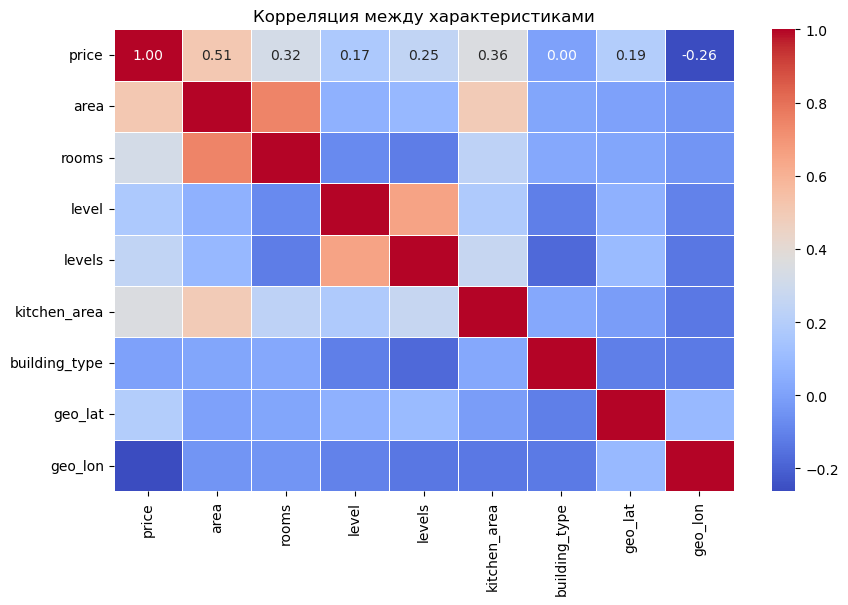

In [7]:
# Тепловая карта корреляции характеристик
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('RussianRealEstateNew.csv').sample(n=20000, random_state=42)
corr = df[['price', 'area', 'rooms', 'level', 'levels', 
           'kitchen_area', 'building_type', 'geo_lat', 'geo_lon']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Корреляция между характеристиками')
plt.show() 